In [1]:
import AgarwalDudikWu as ADW

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import collections
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb

from FairReg import FairReg
from evaluation import get_stats, get_risk_unf_wrt_eps, get_stats_ADW
from evaluation_measures import DP_unfairness, prob_unfairness, prob_unfairness_summary, DP_unfairness_summary
from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions, plot_risk_history,plot_unfairness_history,plot_unfairness_vs_risk, plot_risk_unf_compare, plot_time_compare
from data_prep import get_lawschool_data, get_communities_data, get_frequencies

import time

# Communities and Crime

### ADW statistics (copied from ADW_stats.ipynb)

In [2]:
#training data: X_train+X_unlab

ADW_results_crime_1 = {'risk': {'mean':[0.019184454289390647,
  0.02795554337699633,
  0.039888794614766646,
  0.05070958086303674,
  0.06372588798726009],
  'std':[0.0010695475244603858,
  0.0016351900472801886,
  0.0026766224675669813,
  0.008033720163157756,
  0.008218994144191985]},
 'unf': {0: {'mean':[0.5043731166229097,
   0.28038286914636584,
   0.11969642422453788,
   0.06775097234440607,
   0.05867912230399286],
   'std':[0.04323046723679461,
   0.04569857256615682,
   0.04612620564678026,
   0.021261165364623618,
   0.022278802516881174]},
  1: {'mean': [0.13535891947707485,
   0.07524652079327401,
   0.03212300202831032,
   0.018182369574856517,
   0.01574775167263707],
   'std': [0.011601786734475199,
   0.012264153659926794,
   0.012378917809359678,
   0.005705871855042772,
   0.005978975755329088]}},
 'training_time_hist': [90.65354251861572,
  90.3375928401947,
  85.3242974281311,
  87.95451259613037,
  84.35767006874084,
  255.5059621334076,
  85.90270400047302,
  85.80736947059631,
  85.11192440986633,
  85.23613667488098,
  170.34580516815186,
  171.24332880973816,
  170.90831565856934,
  128.7622950077057,
  251.38031363487244,
  166.4684419631958,
  167.86777234077454,
  172.00146985054016,
  171.77644419670105,
  170.41206288337708,
  314.23589420318604,
  267.73021697998047,
  255.7760989665985,
  313.26034712791443,
  327.1321265697479,
  371.6083068847656,
  229.29685807228088,
  301.39130568504333,
  272.1344676017761,
  257.1872069835663,
  684.6165063381195,
  645.3133339881897,
  746.9980340003967,
  693.0834000110626,
  436.95765709877014,
  523.5313067436218,
  644.2046046257019,
  517.4646425247192,
  428.38349175453186,
  761.1942703723907,
  597.2746143341064,
  467.6374423503876,
  1120.6949090957642,
  919.1567311286926,
  716.4963939189911,
  711.3970160484314,
  870.6917903423309,
  568.3481271266937,
  478.79305958747864,
  700.1749701499939]}

In [3]:
#training data: X_train

ADW_results_crime_2 = {'risk': {'mean':[0.021629530159859495,
  0.031038802773151575,
  0.04227453747840563,
  0.055204694636743955,
  0.06920788325816157],
  'std':[0.0017545504113830302,
  0.0026898902040118342,
  0.0023768048585030943,
  0.011967792485616368,
  0.008978318588231013]},
 'unf': {0: {'mean': [0.4827684501083479,
   0.28475646919146147,
   0.12464786301474609,
   0.07774279679041593,
   0.06432366435437738],
   'std':[0.04482584766625331,
   0.045607628521770194,
   0.03917621243002715,
   0.03329644605937856,
   0.026906733704415056]},
  1: {'mean':[0.12956086200990805,
   0.0764202664922772,
   0.033451822662104266,
   0.02086388156675701,
   0.017262580849098097],
   'std':[0.012029939948770801,
   0.012239746951529415,
   0.010513743910933742,
   0.008935787440855478,
   0.007220976457414857]}},
 'training_time_hist': [45.78951668739319,
  45.77052903175354,
  42.43022966384888,
  40.86864447593689,
  44.41554546356201,
  173.81574130058289,
  44.842381954193115,
  44.87671732902527,
  43.53170919418335,
  137.57763814926147,
  65.62511539459229,
  66.49855828285217,
  85.09984278678894,
  85.15099573135376,
  63.78246212005615,
  88.58906364440918,
  86.3956367969513,
  64.72008991241455,
  89.64155793190002,
  87.94143104553223,
  130.9665002822876,
  110.47078204154968,
  85.59269618988037,
  115.49704360961914,
  116.22706341743469,
  88.4841799736023,
  150.45215344429016,
  107.19774889945984,
  86.23063659667969,
  85.06591176986694,
  387.7301368713379,
  241.84794354438782,
  391.7070233821869,
  215.59491848945618,
  360.6224150657654,
  399.37952494621277,
  388.1810188293457,
  407.68666887283325,
  242.80301523208618,
  410.43470883369446,
  287.2730677127838,
  704.5760641098022,
  553.9340071678162,
  308.56345295906067,
  355.5215890407562,
  314.37719082832336,
  550.3253412246704,
  311.5862889289856,
  245.28069925308228,
  351.581871509552]}

### Training our method

In [11]:
num=10
T=15000

eps_list = []
i_list  = [1, 2, 4, 5, 6, 8, 16, 32, 128, 512]
for i in i_list:
    eps_list+=[[2**(-i), 2**(-i)]]

results_crime = get_risk_unf_wrt_eps(dataset='communities', num=num, T=T, eps_list=eps_list, 
                                     print_details = True, beta='auto', L='auto', 
                                     TRAIN_SIZE=0.4, UNLAB_SIZE=0.4, TEST_SIZE=0.2)

1 / 10  : collecting statistics for eps=[0.5, 0.5]
-----    1 / 10 : training completed, statistics collected
-----    2 / 10 : training completed, statistics collected
-----    3 / 10 : training completed, statistics collected
-----    4 / 10 : training completed, statistics collected
-----    5 / 10 : training completed, statistics collected
-----    6 / 10 : training completed, statistics collected
-----    7 / 10 : training completed, statistics collected
-----    8 / 10 : training completed, statistics collected
-----    9 / 10 : training completed, statistics collected
-----    10 / 10 : training completed, statistics collected
---------------------------------------------------------
2 / 10  : collecting statistics for eps=[0.25, 0.25]
-----    1 / 10 : training completed, statistics collected
-----    2 / 10 : training completed, statistics collected
-----    3 / 10 : training completed, statistics collected
-----    4 / 10 : training completed, statistics collected
-----    5 

In [12]:
results_crime

{'risk': {'mean': [0.021163951958749427,
   0.021163939793051582,
   0.02179000217159035,
   0.02667132910764882,
   0.03392803115562077,
   0.04033561802828968,
   0.04206774784077896,
   0.04285152936802482,
   0.04174730158982162,
   0.0423747743145569],
  'std': [0.0016447045124564693,
   0.0016447207278106198,
   0.0017277301668993297,
   0.0033003963095914897,
   0.004676850149713499,
   0.0044771050813880685,
   0.004558973449586012,
   0.004887532152352839,
   0.005285327020235393,
   0.00519919826171498]},
 'unf': {0: {'mean': [0.4854119450858052,
    0.48540916221240493,
    0.46928985658213024,
    0.30119808451017904,
    0.14561631291423635,
    0.092628804544597,
    0.08308959396005489,
    0.07352522900606029,
    0.08322818123043567,
    0.07542132900757778],
   'std': [0.03543435835441316,
    0.03543440594851057,
    0.04430673512460514,
    0.05391274629695877,
    0.044825267347050675,
    0.033676762535894605,
    0.03232668451792759,
    0.028002956080500064,
   

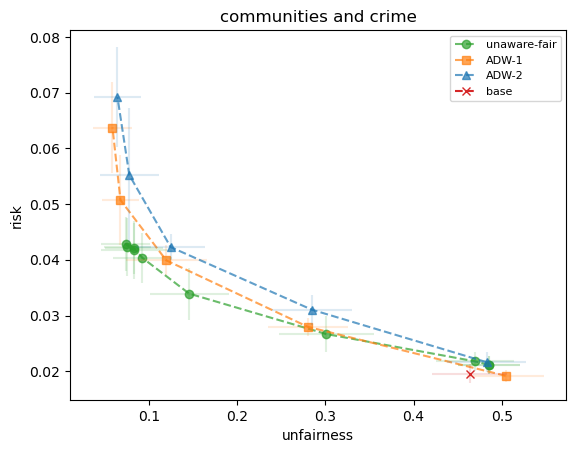

In [13]:
pairs_list = [[results_crime['unf'], results_crime['risk']],
              [ADW_results_crime_1['unf'], ADW_results_crime_1['risk']],
              [ADW_results_crime_2['unf'], ADW_results_crime_2['risk']],
              [results_crime['base_DP'], results_crime['base_risk']]]
model_list = ['unaware-fair','ADW-1','ADW-2','base']
unf_type_list = ['DP','DP','DP', 'DP']
risk_type_list = ['prob','prob', 'prob', 'mse']
markers_list = ['o', 's','^','x']
dataset='communities and crime'
colors=[['tab:green'],['tab:orange'],['tab:blue'],['tab:red']]
S_list=[0]

plot_risk_unf_compare(pairs_list=pairs_list, model_list=model_list, unf_type_list=unf_type_list, risk_type_list=risk_type_list,
                          markers_list=markers_list, dataset=dataset, 
                          x_label = 'unfairness', y_label = 'risk',
                          S_list=S_list, colors = colors, legend_size=8, alpha=0.7, 
                          plot_std=True, annotate=False, loglog=False, start_0=False, label='short', linestyle='dashed')

# Law School

### ADW statistics (copied from ADW_stats.ipynb)

In [24]:
#training data: X_train+X_unlab

ADW_results_law_1 = {'risk': {'mean':[0.011493437499999998,
  0.011493437499999998,
  0.011968568623357798,
  0.01604015685898988,
  0.0182511778823257],
  'std':[0.000640059887945066,
  0.000640059887945066,
  0.0005796406565443473,
  0.0016041381552198077,
  0.003068209111508659]},
 'unf': {0: {'mean':[0.2380625,
   0.2380625,
   0.09555004175130963,
   0.05283712079946525,
   0.05063270229675766],
   'std':[0.05213522831301307,
   0.05213522831301307,
   0.03636354475086835,
   0.027491425276389585,
   0.02766602900628101]},
  1: {'mean':[0.0453452380952381,
   0.0453452380952381,
   0.01820000795263037,
   0.010064213485612391,
   0.009644324247001457],
   'std':[0.009930519678669158,
   0.009930519678669158,
   0.006926389476355847,
   0.00523646195740753,
   0.005269719810720177]}},
 'training_time_hist': [89.0734031200409,
  90.20902442932129,
  88.48083758354187,
  87.88358736038208,
  90.92188882827759,
  90.13062167167664,
  89.00344038009644,
  85.92114162445068,
  89.10214471817017,
  96.45941734313965,
  90.92153644561768,
  87.31686019897461,
  90.55481171607971,
  88.56356048583984,
  90.29450702667236,
  82.60011100769043,
  87.87012553215027,
  87.8022780418396,
  89.31665515899658,
  88.73837375640869,
  237.1581461429596,
  133.63737082481384,
  133.73004364967346,
  133.56724739074707,
  177.83187770843506,
  132.56797242164612,
  178.43536400794983,
  134.39071607589722,
  179.65281414985657,
  133.33519864082336,
  262.15406465530396,
  309.04245162010193,
  482.25990176200867,
  310.5254168510437,
  656.3743484020233,
  438.5928740501404,
  352.2905297279358,
  392.1576180458069,
  483.68868350982666,
  484.2952673435211,
  264.5094974040985,
  317.19134163856506,
  662.2776386737823,
  310.56876707077026,
  480.34878039360046,
  617.9752805233002,
  354.60792875289917,
  398.008962392807,
  485.33692264556885,
  608.7002296447754]}

In [25]:
#training data: X_train
ADW_results_law_2 = {'risk': {'mean':[0.011484375,
  0.011485965203423229,
  0.012110514358429199,
  0.01719773565425585,
  0.019356459963280375], 
  'std':[0.0006429424546567139,
  0.0006343229958237794,
  0.0007804613635147565,
  0.0034421679059363445,
  0.004774412376743943]},
 'unf': {0: {'mean':[0.23543750000000002,
   0.23222859111947375,
   0.1082600844620257,
   0.05462989580178614,
   0.050514938878219985],
   'std':[0.0562625333259177,
   0.05998127154157687,
   0.04722991128376921,
   0.022983963637830958,
   0.01993146902425077]},
  1: {'mean':[0.044845238095238105,
   0.04423401735609024,
   0.02062096846895723,
   0.010405694438435493,
   0.009621893119660949],
   'std':[0.010716673014460528,
   0.011425004103157515,
   0.008996173577860792,
   0.004377897835777358,
   0.0037964702903334506]}},
 'training_time_hist': [46.0025110244751,
  45.52815580368042,
  45.565890073776245,
  46.53616690635681,
  46.107701539993286,
  45.98188519477844,
  43.951051235198975,
  43.812763929367065,
  51.62688589096069,
  51.57475137710571,
  83.10708427429199,
  54.83112072944641,
  55.62662220001221,
  109.72786736488342,
  55.69526505470276,
  55.23397183418274,
  55.06136131286621,
  55.23680663108826,
  55.1396222114563,
  83.04384112358093,
  107.27592396736145,
  79.96491980552673,
  101.1496422290802,
  107.46637225151062,
  82.19356513023376,
  104.03186869621277,
  68.31375408172607,
  72.8010687828064,
  68.17122554779053,
  66.69248294830322,
  244.76522088050842,
  132.91922903060913,
  266.0394866466522,
  226.6684958934784,
  221.63941383361816,
  198.75278735160828,
  221.58688950538635,
  201.48635387420654,
  350.8710744380951,
  289.74950885772705,
  247.8650619983673,
  137.3891212940216,
  290.24754905700684,
  221.28968143463135,
  225.76746535301208,
  200.1957402229309,
  219.2220115661621,
  245.8384141921997,
  247.12435603141785,
  438.2819139957428]}

### Training our method

In [10]:
num=10
T=5000

eps_list = []
i_list  = [0, 1, 2, 4, 5, 6, 8, 16, 32, 64, 128]
for i in i_list:
    eps_list+=[[2**(-i), 2**(-i)]]

results_law = get_risk_unf_wrt_eps(dataset='lawschool', num=num, T=T, eps_list=eps_list, 
                                     print_details = True, beta='auto', L='auto', 
                                     TRAIN_SIZE=0.4, UNLAB_SIZE=0.4, TEST_SIZE=0.2)

1 / 11  : collecting statistics for eps=[1, 1]
-----    1 / 10 : training completed, statistics collected
-----    2 / 10 : training completed, statistics collected
-----    3 / 10 : training completed, statistics collected
-----    4 / 10 : training completed, statistics collected
-----    5 / 10 : training completed, statistics collected
-----    6 / 10 : training completed, statistics collected
-----    7 / 10 : training completed, statistics collected
-----    8 / 10 : training completed, statistics collected
-----    9 / 10 : training completed, statistics collected
-----    10 / 10 : training completed, statistics collected
---------------------------------------------------------
2 / 11  : collecting statistics for eps=[0.5, 0.5]
-----    1 / 10 : training completed, statistics collected
-----    2 / 10 : training completed, statistics collected
-----    3 / 10 : training completed, statistics collected
-----    4 / 10 : training completed, statistics collected
-----    5 / 10 :

In [11]:
results_law

{'risk': {'mean': [0.011497672718490611,
   0.011497752816763492,
   0.011497841827333407,
   0.011567493452721359,
   0.011687636624400194,
   0.011845185062485823,
   0.011743468400506208,
   0.011897317623108831,
   0.01180654488943394,
   0.011949808103763032,
   0.0118981780790591],
  'std': [0.0007583909169830077,
   0.000758357661492659,
   0.0007582829904289239,
   0.000753790424804711,
   0.0007441568632737463,
   0.0007973583539849338,
   0.0007533436713555453,
   0.0008051190888263243,
   0.0007297684953543478,
   0.0009342229306936134,
   0.0009610391293130517]},
 'unf': {0: {'mean': [0.14899990426895407,
    0.14897062675965056,
    0.14885174011393118,
    0.10921234098828514,
    0.06973226056391141,
    0.05707270063989689,
    0.04447720421022579,
    0.05840153802656536,
    0.05091201747947045,
    0.06649471275643212,
    0.04471651131986325],
   'std': [0.04965825202301139,
    0.049673768140796715,
    0.04970542738007524,
    0.051849185772985605,
    0.040743280

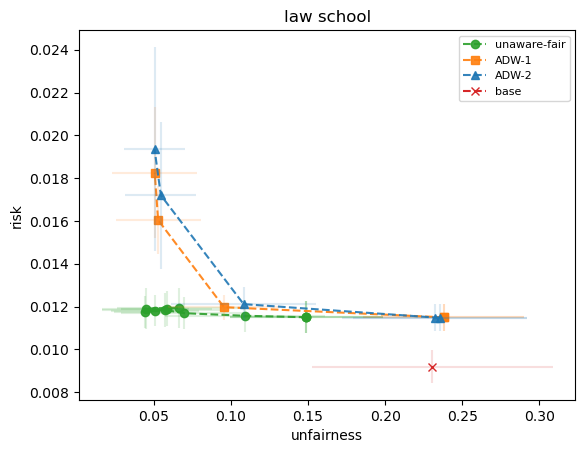

In [12]:
pairs_list = [[results_law['unf'], results_law['risk']],
              [ADW_results_law_1['unf'], ADW_results_law_1['risk']],
              [ADW_results_law_2['unf'], ADW_results_law_2['risk']],
              [results_law['base_DP'], results_law['base_risk']]]
model_list = ['unaware-fair','ADW-1','ADW-2','base']
unf_type_list = ['DP','DP','DP', 'DP']
risk_type_list = ['prob','prob', 'prob', 'mse']
markers_list = ['o', 's','^','x']
dataset='law school'
colors=[['tab:green'],['tab:orange'],['tab:blue'],['tab:red']]
S_list=[0]

plot_risk_unf_compare(pairs_list=pairs_list, model_list=model_list, unf_type_list=unf_type_list, risk_type_list=risk_type_list,
                          markers_list=markers_list, dataset=dataset, 
                          x_label = 'unfairness', y_label = 'risk',
                          S_list=S_list, colors = colors, legend_size=8, alpha=0.9, 
                          plot_std=True, annotate=False, loglog=False, start_0=False, label='short', linestyle='dashed')